    Author: Sandijs Vasilevskis
    Mail: savas20@student.sdu.dk
    Date: 28-05-2021

In [1]:
from datetime import datetime
from collections import Counter
import pickle
import time
import string
import re
import os
import glob
import json
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from textnb import TextNaiveBayes

import spacy

# Downloading the dataset
For the purposes of this project articles from 2019 and 2020 are used. Note that the articles are sorted by the date they appeared on the front pages of news outlets so the article itself can be somewhat older and there will be article duplicates across time-stamps (one article could have stayed on front page for a bit).
- Article data is described here: http://sciride.org/news.html
- The processed articles are available here: https://news-mine.s3.eu-west-2.amazonaws.com/processed.tar.gz
- With documentation here: http://sciride.org/news.html#datacontent

# Preprocessing Data
The following steps are performed to preprocess news dataset:
- Filtering articles by news outlet domain name, language and dates
- Tagging articles related to COVID-19
- Prepare training and test datasets

In [2]:
def filter_articles(domain_name='bbc.com', date_from='2019-01-01', date_to='2021-01-01'):
    """This function retrieves the list of file paths from mayor online news outlets dataset.
    These processed articles can be downloaded here: 
        https://news-mine.s3.eu-west-2.amazonaws.com/processed.tar.gz
    N.B.:
        This function can be used assuming that the compressed file from the link above is downloaded and
        extracted under the 'release' folder and ontains all the news domain subfolders. 
        Otherwise the file path in function glob.glob() can be altered.
    Args:   
        domain_name (str): Subfolder name of the specific online news outlet i.e. 'bbc.com'
        date_from (str): Start date string i.e.'2019-01-01'
        date_to (str): End date string i.e.'2021-01-01'
    Returns:
        file_paths (list): File paths from the selected news article domain and corresponding time period.
    """
    date_from = datetime.strptime(date_from, "%Y-%m-%d")
    date_to = datetime.strptime(date_to, "%Y-%m-%d")
    
    file_paths = []
    for file_name in glob.glob(f'release\\{domain_name}\\per_day\\*.gz'):
        dt_string = os.path.basename(file_name).split('.')[0]
        dt_object = datetime.strptime(dt_string, "%Y%m%d")
    
        if date_to >= dt_object >= date_from:            
            file_path = os.path.join(os.getcwd(), file_name)
            file_paths.append(file_path)
            
    return file_paths   

print(filter_articles()[:5])

['C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190101.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190102.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190103.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190104.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190105.gz']


### Combine all filepaths from available news outlets

In [3]:
# Read .json file with domain names and outlet language
file = open('available_outlets.json', 'r', encoding='utf-8')
outlets = json.loads(file.read())

# Filter news outlets written in English only
outlets_en = {}
for k, v in outlets.items():    
    if v['lng'][0] == 'en':        
        outlets_en[k] = {'country': v['country']}
        
# List of domain names to iterate over
domain_names = list(outlets_en.keys())

# Collect all file paths (2019 - 2020)
file_paths = []
for domain_name in domain_names:    
    file_paths.extend(filter_articles(domain_name, date_from='2019-01-01', date_to='2021-01-01'))
    
print(len(file_paths))
print(file_paths[:5])

55160
['C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190101.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190102.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190103.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190104.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190105.gz']


### Tagging articles related to COVID-19 

In [4]:
def tag_covid19(text):
    """This function uses regular expressions to identify if the text is COVID-19 related or not.
    One can manipulate the regular expressions to obtain more procesize article categorization.
     """
    # Note that '-' is replaced with ' ' to shorten the synonym list
    text = text.replace('-', ' ')
    
    # COVID-19 related keywords
    covid19_synonyms_list = ['covid',
                             r'covid(.*?)19',                             
                             'coronavirus disease 19',
                             r'severe acute respiratory syndrome coronavirus(.*?)2',                             
                             r'sars(.*?)cov(.*?)2',                          
                             r'2019(.*?)n(.*?)cov',                     
                             r'n(.*?)cov(.*?)2019',
                             'coronavirus',
                             'coronavirus 2019',
                             'wuhan pneumonia',
                             'wuhan virus',
                             'wuhan coronavirus',
                             r'coronavirus(.*?)2',
                            'lockdown', 'quarantine', 'pandemic'# Consider removing these very general kwords
                            ]
    # ignore casing
    if re.compile('|'.join(covid19_synonyms_list), re.IGNORECASE).search(text):            
        return True
    else:
        return False
    
tag_covid19('This text is about covid-19')

True

In [5]:
def extract_article_data(file_path):
    """This function reads the relevant information from zipped article files in the file path.
    """
    dt_string = os.path.basename(file_path).split('.')[0]
    dt_object = datetime.strptime(dt_string, "%Y%m%d")
    
    d = json.load(gzip.open(file_path))
    
    article_list = []
    
    for article_id, article_dict in d.items():        
        dct = {'article_id': article_id,
               'domain': file_path.split('\\')[-3],
               'title': article_dict['title'], 
               'description': article_dict['description'], 
               'date': dt_object}
        dct['is_covid'] = any([tag_covid19(article_dict['description']), tag_covid19(article_dict['title'])])
        # dct['is_covid_tag'] = article_dict['is_covid'] # Use already available tags from processed articles files        
        article_list.append(dct)
        
    # Remove duplicated articles and missing values    
    df = pd.DataFrame(article_list).drop_duplicates().dropna()
    return df
    
df = extract_article_data(filter_articles()[-1])
df.head()

,article_id,domain,title,description,date,is_covid
0,cd06a6b02378991447309a60ed27bc9c,bbc.com,US election 2020: The young people struggling ...,How the pandemic is changing the economic pros...,2020-10-17,True
1,e0ddb2d43e898d0cf212baef9963618f,bbc.com,BBC - Travel - The private language of Venice,Although many travellers assume that the “auth...,2020-10-17,False
2,6f0b26eaa2adf75b51edb1eb8fa0bbb4,bbc.com,The African lake with explosive power - BBC Fu...,In central Africa is a deep lake that has a da...,2020-10-17,False
3,2c5da074e2b70b2e9e1f6e7b0948cb97,bbc.com,Said Benrahma: West Ham sign Algeria winger fr...,West Ham sign Algeria winger Said Benrahma fro...,2020-10-17,False
4,336121e33d92e3fddeb2dad94d20098c,bbc.com,Salisbury Novichok-poisoned officer Nick Baile...,"Det Sgt Nick Bailey ""had to admit defeat"" afte...",2020-10-17,False


### Combine data from all available news outlets

In [7]:
start = time.time()

# Combine all news articles into a DataFrame
df_list = []
for file_path in file_paths:      
    try:
        df_list.append(extract_article_data(file_path))
    except:
        continue
    
df = pd.concat(df_list)

end = time.time()
print(f'Time to extract data: {round((end - start)/ 60, 1)} minutes')
df.shape

Time to extract data: 33.5 minutes


(9519797, 6)

In [ ]:
# Save DataFrame to .csv (.bz2) file to reload later (~2.8 GB)
#df.to_csv('article_data.csv', index=False)
#df.to_csv('article_data.bz2', compression='bz2', index=False)

In [15]:
# Load .csv file with extracted data (Select spcific columns)
df = pd.read_csv('article_data.csv', usecols=['description', 'is_covid']).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9231643 entries, 0 to 9519796
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   description  object
 1   is_covid     bool  
dtypes: bool(1), object(1)
memory usage: 149.7+ MB


In [9]:
# Conisder a random 50% sample of the DataFrame without replacement to shrink the dataset
#df = df.sample(frac=0.5, replace=False, random_state=1)
#df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759898 entries, 1175301 to 8703545
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   description  object
 1   is_covid     bool  
dtypes: bool(1), object(1)
memory usage: 77.2+ MB


## Training and Test Datasets
Split the dataset - 80% for training and 20% for testing the classifier.

### Training data
Hint: picking articles with COVID-19 keyword in titles/descriptions would seed your training set of ‘positive’ articles whereas 2019 articles can be taken as
the ‘negative’ set.

In [17]:
# Selecting article description text
X, y = df.description, df.is_covid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [18]:
# Summarize dataset dimensions
print('Training data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)

Training data: (8308478,) (8308478,)
Test data: (923165,) (923165,)


In [19]:
# Check the class balance after splitting data
print(y_train.value_counts())
print(y_test.value_counts())

False    7345301
True      963177
Name: is_covid, dtype: int64
False    815966
True     107199
Name: is_covid, dtype: int64


In [20]:
# Check the class balance after splitting data
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

False    0.884073
True     0.115927
Name: is_covid, dtype: float64
False    0.883879
True     0.116121
Name: is_covid, dtype: float64


## Naive Bayes Text Classifier
Naive Bayes Text classifier for Binary classification is created from scratch in the following manner by:
- Calculating Prior Probabilities for given class labels
- Calculating Conditional Probabilities with each attribute for each class
- Multiplying same class Conditional Probability
- Multiplying Prior probability with the previous step probability
- Adding Laplace smoothing to avoid zero probability for words that are not present in the training set
- Determining the class with the highest score (posterior probability)

Furthermore,  the classifier is implemented as a Python class object called TextNaiveBayes. The class objects implement the following text processing pipeline and methods:
- Tokenization of the data (from text to sentences to words), removing punctuation and English stopwords
- Normalization of the tokenized text via stemming (or lemmatization)
- Creating a vocabulary of distinct word tokens
- Counting word tokens in each class (is_covid, not_covid)
- Fitting the training data
- Predicting on the test data
- Estimating the performance of the classifier using accuracy score: *(TN + TP)/(TN + TP + FN + FP)*

Classifier can be further used to determine whether the article is about COVID-19 or not.

In [33]:
# Train the classifier
CovidNB = TextNaiveBayes()
CovidNB.fit(X_train, y_train)

In [41]:
print(f"Vocabulary (not COVID-19): {len(CovidNB.word_counts['not_target'])}")
print(f"Vocabulary (COVID-19): {len(CovidNB.word_counts['is_target'])}")

Vocabulary (not COVID-19): 368533
Vocabulary (COVID-19): 85348


In [36]:
CovidNB.log_class_priors

-6.049733455231958

In [43]:
len(CovidNB.vocab)

391059

In [44]:
# Sort COVID-19 related word tokens by count
d = CovidNB.word_counts['is_target']
dict(sorted(d.items(), key=lambda x: x[1], reverse=True))

{'coronavirus': 405695.0,
 'covid': 179103.0,
 'pandem': 154347.0,
 'new': 122401.0,
 'lockdown': 88388.0,
 'peopl': 84199.0,
 'said': 82743.0,
 'case': 78776.0,
 'health': 72157.0,
 'say': 66326.0,
 'us': 65469.0,
 'test': 62102.0,
 'state': 58902.0,
 'outbreak': 56728.0,
 'govern': 56549.0,
 'countri': 56515.0,
 'week': 54192.0,
 'one': 52218.0,
 'presid': 52134.0,
 'home': 51365.0,
 'trump': 50945.0,
 'report': 48988.0,
 'world': 48821.0,
 'day': 48265.0,
 'spread': 46424.0,
 'year': 45737.0,
 'time': 45257.0,
 'could': 43134.0,
 'death': 41291.0,
 'virus': 40841.0,
 'first': 40590.0,
 'work': 37020.0,
 'number': 36024.0,
 'crisi': 35871.0,
 'help': 35661.0,
 'infect': 35278.0,
 'two': 35044.0,
 'nation': 34684.0,
 'amid': 34482.0,
 'month': 33878.0,
 'show': 32676.0,
 'mani': 31880.0,
 'offici': 31820.0,
 'get': 31555.0,
 'may': 31366.0,
 'busi': 31337.0,
 'due': 31299.0,
 'public': 31167.0,
 'face': 30512.0,
 'hospit': 30289.0,
 'news': 30101.0,
 'citi': 30046.0,
 'like': 29919.0,

### Accuracy score on test data

In [42]:
# Accuracy score on test data
CovidNB.score(X_test, y_test)

0.9631192690364128

### Save the trained classifier model
In order to reuse the model after some time and not train it from the scratch.

In [34]:
# Save the model to disk
filename = 'Covid19_Text_Classifier'
pickle.dump(CovidNB, open(filename, 'wb'))

In [65]:
# Load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test[:100], y_test[:100])
print(result)

0.93


# Analysis

Using the classifier, estimate the proportion of articles on COVID-19 in your dataset:
- As proportion of all articles in 2020
- As proportion of all articles in each month of 2020
- As proportion of articles in an outlet (e.g. BBC) in 2020

In [45]:
# Load .csv file with extracted data (Select specific columns)
df = pd.read_csv('article_data.csv', usecols=['domain', 'description', 'date'], parse_dates=['date']).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9231643 entries, 0 to 9519796
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   domain       object        
 1   description  object        
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 281.7+ MB


In [51]:
# Filter articles by date, select year 2020
date_mask = (df['date'] >= datetime(2020,1,1)) & (df['date'] < datetime(2021,1,1))
df_2020 = df.loc[date_mask, :]
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4118141 entries, 22086 to 9519796
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   domain       object        
 1   description  object        
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 125.7+ MB


## A proportion of COVID-19 articles in 2020
Using the pretrained Naive Bayes classifier to predict article description is related to COVID-19

In [61]:
# Predict on test data of year 2020
y_predicted = CovidNB.predict(df_2020.description)
len(y_predicted)

4118141

In [60]:
# Add predicted values column
df_2020.loc[:, ['is_covid']] = y_predicted

In [62]:
# Save DataFrame to .csv (.bz2) file to reload later (~128 MB)
#df_2020.to_csv('predicted_article_data.bz2', compression='bz2', index=False)

#  Load .csv file with predicted data for 2020
#df_2020 = pd.read_csv('predicted_article_data.bz2', compression='bz2')

In [174]:
df_2020_counts = df_2020.loc[:, ['is_covid']].value_counts(normalize=True)
df_2020_counts

is_covid
0           0.787675
1           0.212325
dtype: float64

In [158]:
# Select one news outlet - BBC News
domain_mask = df_2020['domain'] == 'bbc.com'
df_bbc = df_2020.loc[domain_mask, ['is_covid']]

In [161]:
df_bbc_counts = df_bbc.value_counts(normalize=True)
df_bbc_counts

is_covid
0           0.783304
1           0.216696
dtype: float64

In [182]:
proportions_dict = {'All Outlets': list(df_2020_counts), 'BBC News': list(df_bbc_counts)}
df_proportions = pd.DataFrame.from_dict(proportions_dict, orient='index').sort_index(axis=1, ascending=False)
df_proportions

,1,0
All Outlets,0.212325,0.787675
BBC News,0.216696,0.783304


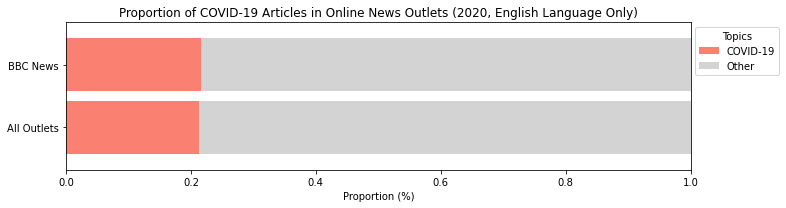

In [188]:
# Plot proportions
fig, ax = plt.subplots(figsize=(11, 3))
df_proportions.plot.barh(stacked=True, width=0.85, rot=0, color={0: 'lightgrey', 1: 'salmon'}, ax=ax)
plt.xlabel('Proportion (%)')
ax.set_xlim(xmax=1.0)
plt.title('Proportion of COVID-19 Articles in Online News Outlets (2020, English Language Only)')
plt.legend(['COVID-19', 'Other'], title='Topics', bbox_to_anchor = (1.15, 1.0), loc='upper right')
plt.tight_layout()
#plt.savefig('./Results/covid19_proportion_2020.png', dpi=200)
plt.show()

## A proportion of COVID-19 articles in each month of 2020

In [138]:
# Group by month (December is missing)
df_monthly_counts = (df_2020.loc[:, ['is_covid', 'date']]
             .groupby(by=df_2020['date'].dt.month, dropna=False)['is_covid']
             .value_counts(normalize=True)
             .unstack()
             .sort_index(axis=1, ascending=False))
df_monthly_counts

is_covid,1,0
date,,
1,0.027516,0.972484
2,0.079383,0.920617
3,0.349573,0.650427
4,0.409427,0.590573
5,0.312141,0.687859
6,0.191630,0.808370
7,0.196984,0.803016
8,0.167587,0.832413
9,0.153199,0.846801


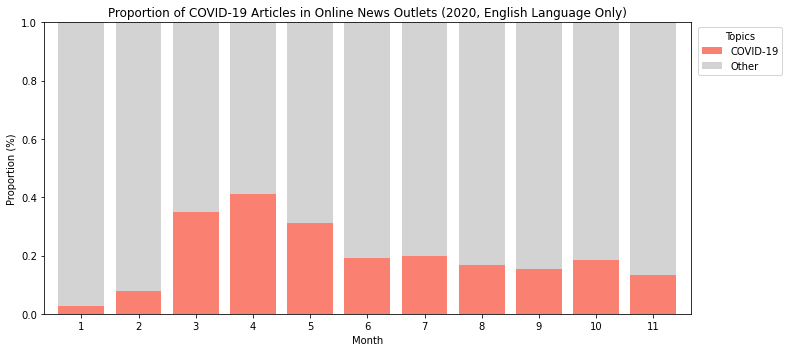

In [189]:
# Plot monthly proportions
fig, ax = plt.subplots(figsize=(11, 5))
df_monthly_counts.plot.bar(stacked=True, width=0.8, rot=0, color={0: 'lightgrey', 1: 'salmon'}, ax=ax)
ax.set_ylim(ymax=1.0)
plt.ylabel('Proportion (%)')
plt.xlabel('Month')
plt.title('Proportion of COVID-19 Articles in Online News Outlets (2020, English Language Only)')
plt.legend(['COVID-19', 'Other'], title='Topics', bbox_to_anchor = (1.15, 1.0), loc='upper right')
plt.tight_layout()
#plt.savefig('./Results/covid19_proportion_monthly_2020.png', dpi=200)
plt.show()

# Named Entity Recognition (NER)
Extract the Named Entities - in most cases these will correspond to names of people, places and organizations. You can create your own named entities extractor or use an off-the-shelf one. In either case you should be able to describe in your final report what the algorithm is doing, beyond simply stating the library you used.

Based on the Named Entities analyze what are the most commonly mentioned Named Entities with respect to COVID-19.

For example, 'en_core_web_sm' is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, vectors, syntax and named entities.

A named entity is a “real-world object” that’s assigned a name – for example, a person, a country, a product or a book title. spaCy can recognize various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn’t always work perfectly and might need some tuning later, depending on your use case.

In [ ]:
#!python -m spacy download en_core_web_md

In [ ]:
# Loading pretrained statistical model for NER
# Doc object that holds all information about the tokens, their linguistic features and their relationships
nlp = spacy.load("en_core_web_sm")

## Most commonly mentioned Named Entities with respect to COVID-19

In [ ]:
# Load .csv file with extracted data (Select spcific columns)
df = pd.read_csv('article_data.csv', usecols=['description', 'is_covid'], parse_dates=['date']).dropna()

In [32]:
# Filter to have only COVID-19 related articles
mask_covid19 = df['is_covid'] == True
df_covid19 = df[mask_covid19]
df_covid19.info()

[('Larry Page', 'PERSON'),
 ('Google', 'ORG'),
 ('Apple', 'ORG'),
 ('covid-19', 'DATE')]

In [ ]:
def get_entity_counts(entities):
    """This function returns a dictionary of entity counts given an entity list."""
    return dict(Counter(entities))

In [ ]:
# Gather Named Entities from COVID-19 related articles
entity_list = []
for description in df_covid19.description[:10]:
    # Processing text with nlp object that returns a Doc object
    # Doc object contains information about the tokens, their linguistic features and their relationships
    doc = nlp(description)
    # Text and label of named entity span
    ents = [ent.text for ent in doc.ents]
    entity_list.append(ents)

In [21]:
doc.ents

(Larry Page,)

In [33]:
from spacy import displacy
displacy.render(doc, style="ent")

# Using scikit-learn classifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [21]:
# Builds a dictionary of features and transforms documents to feature vectors and convert our text documents to a
# matrix of token counts (CountVectorizer)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# Transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [24]:
# Text classifier pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Fitting our train data to the pipeline
text_clf.fit(X_train, y_train)

# Predicting on test data
text_clf.score(X_test, y_test)

0.929617141149857